# **A/B тестирование для мобильного приложения**

Мобильное приложение для магазина по продаже продуктов питания. Выдвинута гипотеза о том, что смена шрифтов улучшит качество обслуживания по количеству клиентов, совершающих каждое событие.

Пользователи разбиты на 2 группы:
*   247 -- контрольная группа со старыми шрифтами;
*   248 -- экспериментальная с новыми шрифтами.


Описание данных

|Признак|Комментарий|
|--:|:--|
|`EventName`|название события|
|`DeviceIDHash`|уникальный идентификатор пользователя|
|`EventTimestamp`|время события|
|`ExpId`|номер группы|

Анализ воронки событий
- Распределение событий: какие события и в каком количестве.
- Сколько пользователей совершали каждое из этих событий?
- Вворонка событий: какая доля пользователей проходит на следующий шаг воронки? На каком шаге теряется больше всего пользователей?
Доля пользователей доходит от первого события до оплаты.

Анализ результатов эксперимента
- Сколько пользователей в каждой группе?
- Доля пользователей, совершивших каждое из событий.
- Проверка гипотезы о наличие значимых отличий по результатам теста.

In [ ]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import math
import scipy.stats as st

In [ ]:
df = pd.read_csv('/content/A_B testing_dataset.csv')
df.head(2)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248
1,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248


In [ ]:
df.ExpId.value_counts()

248    85747
247    78075
Name: ExpId, dtype: int64

In [ ]:
df.duplicated().sum()

290

In [ ]:
df.drop_duplicates(inplace = True) # удаляем дубли

In [ ]:
A = set(df[df.ExpId == 247].DeviceIDHash.unique())
B = set(df[df.ExpId == 248].DeviceIDHash.unique())
A.intersection(B) # проверяем на пересечение (нет ли одинаковых пользователей в гр. А и в гр. В)

set()

In [ ]:
df.rename(columns = {'EventName' : 'event_name', 'DeviceIDHash' : 'device_id_hash', 'EventTimestamp' : 'event_timestamp', 'ExpId' : 'exp_id'}, inplace = True) # корректировка заголовков

In [ ]:
df.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

In [ ]:
df['event_timestamp'] = pd.to_datetime(df['event_timestamp'], origin = 'unix') # работа с датой
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163532 entries, 0 to 163821
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       163532 non-null  object        
 1   device_id_hash   163532 non-null  int64         
 2   event_timestamp  163532 non-null  datetime64[ns]
 3   exp_id           163532 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 6.2+ MB


In [ ]:
df.groupby('device_id_hash').agg(count_device_id = ('device_id_hash', 'count')).reset_index().sort_values(by = 'count_device_id', ascending = False) # аномальное количество сессий

,device_id_hash,count_device_id
3462,6304868067479728361,2307
2496,4623191541214045580,1768
3766,6932517045703054087,1439
930,1754140665440434215,1221
2556,4713748699910253089,824
...,...,...
3040,5614436717776464130,1
569,1083512226259476085,1
2199,4096007885698937181,1
4374,7982248574455189469,1


# **EDA**

In [ ]:
df.shape[0] # количество событий

163532

In [ ]:
display(df['event_name'].unique()) # список наименований уникальных событий
display(df['event_name'].nunique()) # кол-во наименований уник. соб.

array(['PaymentScreenSuccessful', 'CartScreenAppear', 'MainScreenAppear',
       'Tutorial', 'OffersScreenAppear'], dtype=object)

5

In [ ]:
print(f'в среднем приходится {int(df.shape[0]/df.device_id_hash.nunique())} события на 1-го пользователя')

в среднем приходится 32 события на 1-го пользователя


In [ ]:
print(f'Дата начала теста: {df.event_timestamp.min()}')
print(f'Дата окончания теста: {df.event_timestamp.max()}')


Дата начала теста: 2019-07-25 11:28:47
Дата окончания теста: 2019-08-07 21:12:25


In [ ]:
# создание нового столбца с датой без времени
df['event_date'] = df['event_timestamp'].dt.date
df.head(2)

,event_name,device_id_hash,event_timestamp,exp_id,event_date
0,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
1,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25


In [ ]:
# гистограмма количества событий по дате
df_count_events = df.groupby('event_date').agg(count_event_days = ('event_name', 'count')).reset_index()

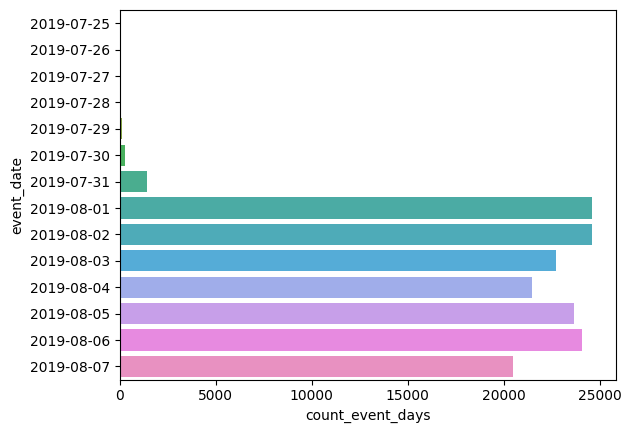

In [ ]:
sns.barplot(data = df_count_events, y = 'event_date', x = 'count_event_days');

In [ ]:
# создание датафрейма с учетом графика. актуальное кол-во событий начинается 1 авг 2019
df = df[df['event_date'] > dt.datetime(2019, 7, 31).date()]

In [ ]:
df.exp_id.value_counts()

248    84563
247    77022
Name: exp_id, dtype: int64

# **Анализ воронки событий**

In [ ]:
df_count_ev = df.groupby('event_name').agg(count_each_event = ('device_id_hash', 'count'))

In [ ]:
df_count_ev.sort_values(by = 'count_each_event', ascending = False).reset_index() # какие события и в каком количестве

,event_name,count_each_event
0,MainScreenAppear,79652
1,OffersScreenAppear,31566
2,CartScreenAppear,27613
3,PaymentScreenSuccessful,22066
4,Tutorial,688


In [ ]:
df.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id',
       'event_date'],
      dtype='object')

In [ ]:
# Количество уникальных пользователей совершали каждое из этих событий
df_count_users = df.groupby('event_name').agg(count_users = ('device_id_hash', 'nunique')).reset_index()
df_count_users.sort_values(by = 'count_users', ascending = False)

,event_name,count_users
1,MainScreenAppear,4969
2,OffersScreenAppear,3051
0,CartScreenAppear,2468
3,PaymentScreenSuccessful,2339
4,Tutorial,562


In [ ]:
# доля пользователей проходит на следующий шаг воронки
# уникальные пользователи, которые совершили события (по каждой группе)
df_ab = pd.merge(df[df.exp_id == 247].groupby('event_name').agg(count_247 = ('device_id_hash', 'nunique')).reset_index().\
sort_values(by = 'count_247', ascending = False),
df[df.exp_id == 248].groupby('event_name').agg(count_248 = ('device_id_hash', 'nunique')).reset_index().\
sort_values(by = 'count_248', ascending = False))
df_ab

,event_name,count_247,count_248
0,MainScreenAppear,2476,2493
1,OffersScreenAppear,1520,1531
2,CartScreenAppear,1238,1230
3,PaymentScreenSuccessful,1158,1181
4,Tutorial,283,279


In [ ]:
df_ab = df_ab[df_ab["event_name"].str.contains("Tutorial")== False ] # без Tutorial

<ipython-input-29-79d2e7328e96>:2: UserWarning:

FixedFormatter should only be used together with FixedLocator



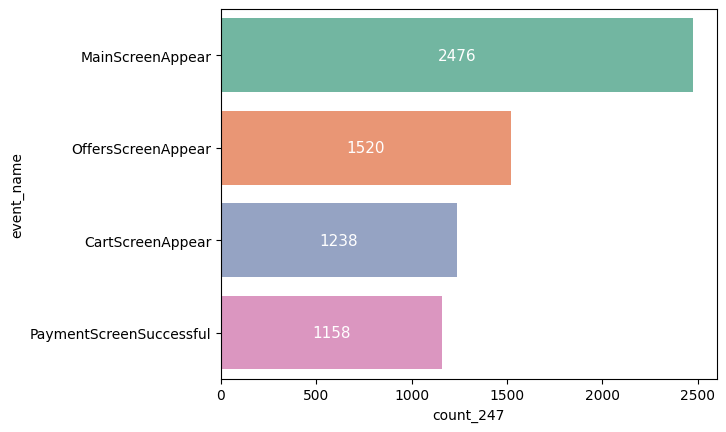

<ipython-input-29-79d2e7328e96>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



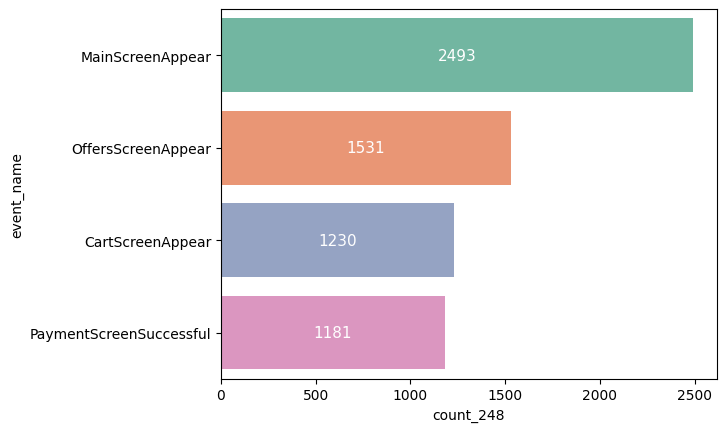

In [ ]:
ax = sns.barplot(data = df_ab, y = 'event_name', x = 'count_247', palette = 'Set2');
ax.set_xticklabels(ax.get_xticklabels())
for label in ax.containers:
    ax.bar_label(label, fontsize = 11, label_type = 'center', color = 'white')
plt.show()

ax = sns.barplot(data = df_ab, y = 'event_name', x = 'count_248', palette = 'Set2');
ax.set_xticklabels(ax.get_xticklabels())
for label in ax.containers:
    ax.bar_label(label, fontsize = 11, label_type = 'center', color = 'white')
plt.show()

In [ ]:
# воронка с использованием библиотеки Plotly
from plotly import graph_objects as go

fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа 248', # группа
    y = df_ab['event_name'], # название события
    x = df_ab['count_248'], # кол-во
    textposition = "inside", # положение текста (надписи % на графике)
    textinfo = "value+percent total+percent previous")) # показывает количество + процент от общего + процент от предыдущего

fig.add_trace(go.Funnel(
    name = 'Группа 247',
    orientation = "h",
    y = df_ab['event_name'],
    x = df_ab['count_247'],
    textposition = "inside",
    textinfo = "value+percent total+percent previous"))

fig.update_layout(
    autosize=False,
    width=1200,
    height=500)

fig.update_layout(
    title = "Воронка событий",
    legend_title = "Описание",
    font = dict(
        size = 18,
        color = "RebeccaPurple")
)

fig.show()

In [ ]:
# На каком шаге теряете больше всего пользователей?
print ('Больше всего пользователей теряем на шаге открытия экрана с предложением товара/услуги - по 39 % по каждой группе')

Больше всего пользователей теряем на шаге открытия экрана с предложением товара/услуги - по 39 % по каждой группе


In [ ]:
# Доля пользователей доходит от первого события до оплаты? paymentscreensuccessful
print ('Доля пользователей доходит от первого события до оплаты - одинаково по каждой группе - по 18 % ')

Доля пользователей доходит от первого события до оплаты - одинаково по каждой группе - по 18 % 


## **Анализ результатов эксперимента**

In [ ]:
# Сколько пользователей в каждой группе?
df_users_by_group = df.groupby('exp_id').agg(unique_users_ab = ('device_id_hash', 'nunique'))
df_users_by_group

,unique_users_ab
exp_id,
247,2513
248,2537


In [ ]:
df_ab

,event_name,count_247,count_248
0,MainScreenAppear,2476,2493
1,OffersScreenAppear,1520,1531
2,CartScreenAppear,1238,1230
3,PaymentScreenSuccessful,1158,1181


In [ ]:
#  доля пользователей, совершивших каждое из событий
df_ab.loc[:, 'percent_gr_247'] = df_ab['count_247'] / df_users_by_group.loc[247][0]
df_ab.loc[:, 'percent_gr_248'] = df_ab['count_248'] / df_users_by_group.loc[248][0]
df_ab

<ipython-input-35-3c0d4a4400b8>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-35-3c0d4a4400b8>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,event_name,count_247,count_248,percent_gr_247,percent_gr_248
0,MainScreenAppear,2476,2493,0.985277,0.982657
1,OffersScreenAppear,1520,1531,0.604855,0.603469
2,CartScreenAppear,1238,1230,0.492638,0.484825
3,PaymentScreenSuccessful,1158,1181,0.460804,0.465510


Формулировка гипотез:

Н0 - Нет статистически значимого различия между количеством пользователей (т.е. их доли одинаковы), совершивших каждое из событий по гр. А и гр. В.


Н1 - Есть статистически значимая разница между количеством пользователей (т.е. их доли различны), совершивших каждое из событий по гр. А и гр. В.

In [ ]:
df_ab_i = df_ab.set_index('event_name') # столбец индексами, чтобы потом применить loc

In [ ]:
df_ab_i.loc['MainScreenAppear', 'percent_gr_247'].round(6)

0.985277

In [ ]:
def z_test(group1, group2, event, alpha):  # функция для проведения Z - теста
    p1_ev = df_ab_i.loc[event, group1]
    p2_ev = df_ab_i.loc[event, group2]
    p1_us = df_users_by_group.loc[247][0]
    p2_us = df_users_by_group.loc[248][0]
    p1 = p1_ev / p1_us
    p2 = p2_ev / p2_us
    difference = p1 - p2
    p_combined = (p1_ev + p2_ev) / (p1_us + p2_us)
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1 / p1_us + 1 / p2_us))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('Группы {} и {}. Событие -- {}. P-значение --  {:.2f}. Уровень значимости -- {}'.format(group1, group2, event, p_value, alpha ))
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу -- между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, статистически значимой разницы между долями гр А и гр В нет")

In [ ]:
for event in df_ab_i.index: # функцию циклом по каждому наименованию события
    z_test('count_247', 'count_248', event, 0.05)

Группы count_247 и count_248. Событие -- MainScreenAppear. P-значение --  0.46. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, статистически значимой разницы между долями гр А и гр В нет
Группы count_247 и count_248. Событие -- OffersScreenAppear. P-значение --  0.92. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, статистически значимой разницы между долями гр А и гр В нет
Группы count_247 и count_248. Событие -- CartScreenAppear. P-значение --  0.58. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, статистически значимой разницы между долями гр А и гр В нет
Группы count_247 и count_248. Событие -- PaymentScreenSuccessful. P-значение --  0.74. Уровень значимости -- 0.05
Не получилось отвергнуть нулевую гипотезу, статистически значимой разницы между долями гр А и гр В нет


## Вывод.

гипотезу Н0 принимаем по всем видам событий:

Нет статистически значимого различия между количеством пользователей (т.е. их доли), совершивших каждое из событий по гр. А и гр. В.


**Иными словами: разницы (стат. значимой) между долями контрольной и эксперементальной группами нет - размер шрифта не влияет на результаты продаж.**